In [79]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


from src.path_loss import PathLossInHIndoorOffice, PathLossInHShoppingMalls
from src.network_sim import NetworkSimulator
from src.algorithm import wmmse, stochastic_wmmse
from src.sc import SyntheticControl
from src.experiment import ExperimentInterferenceModelComparison

%reload_ext autoreload
%autoreload 2
%aimport src

In [80]:
frequency_Hz= 50 * 1e9 # Hz
distance_m = 50
sample_size = 10

In [81]:
pd.DataFrame({
    'PathLossInHIndoorOffice':[PathLossInHIndoorOffice().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
    'PathLossInHShoppingMalls': [PathLossInHShoppingMalls().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
})

,PathLossInHIndoorOffice,PathLossInHShoppingMalls
0,-138.924926,-114.778236
1,-92.521022,-110.410510
2,-135.620269,-102.108148
3,-92.997929,-99.652684
4,-114.973565,-102.858764
5,-142.746350,-94.969171
6,-134.411008,-100.722949
7,-94.385146,-114.269186
8,-118.736892,-103.312729
9,-122.768294,-100.367548


In [82]:
simulator = NetworkSimulator(Tx_radius=200, Rx_radius=100, num_Tx_netA=3, num_Rx_per_Tx_netA=5, num_Tx_netB=2, num_Rx_per_Tx_netB=5)

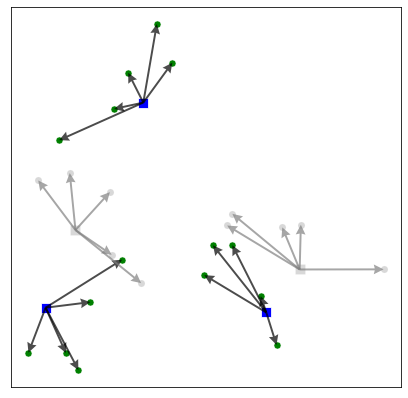

In [83]:
simulator.plot_network()

In [84]:
pd.DataFrame(simulator.gain_mat_dBm)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-121.045228,-99.654267,-109.486528,-95.249286,-105.359327,-166.416437,-137.689090,-163.287940,-165.393698,-169.412239,...,-133.876909,-147.809453,-117.667376,-150.436276,-136.250314,-155.833298,-146.398587,-146.237918,-173.228124,-136.487453
1,-170.971300,-160.056750,-150.011306,-147.890030,-164.152095,-122.256108,-114.445707,-98.725911,-124.644563,-119.727584,...,-127.948495,-117.152769,-149.773371,-115.708170,-137.148463,-163.354274,-164.138795,-143.380710,-157.050182,-155.394093
2,-165.441175,-177.302524,-165.982848,-168.580277,-162.796427,-139.268578,-142.481808,-143.601501,-146.369583,-137.694405,...,-142.686127,-137.024278,-162.806020,-133.150684,-162.449270,-117.867773,-113.809305,-113.420289,-131.906855,-132.956655
3,-148.438085,-134.468867,-121.041437,-133.805911,-147.623090,-135.094245,-101.063651,-116.053414,-146.055992,-140.621169,...,-118.249739,-119.912215,-108.039542,-113.515975,-114.007601,-144.410207,-149.922435,-145.189176,-154.591862,-126.044706
4,-167.495606,-159.744860,-154.231497,-157.374575,-162.452033,-159.626404,-132.884683,-151.640577,-165.494100,-153.318416,...,-152.545002,-144.752635,-158.508273,-130.933522,-152.338862,-109.729283,-111.951991,-106.259343,-120.005857,-131.485802


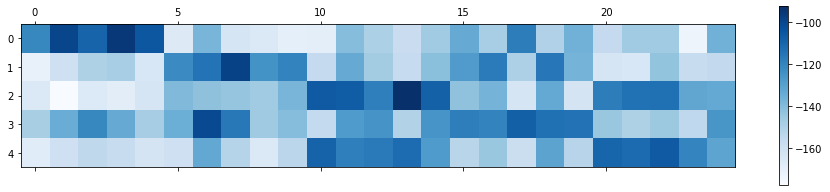

In [85]:
simulator.plot_gain_mat()

## Model Comparisons

In [86]:
simulator.weighted_sum_rate_Gnats([200 for i in range(simulator.num_Rx)], Rx_weights=np.ones(simulator.num_Rx))

183.39234665974948

In [87]:
# model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
# model_comparison.data_generation(num_samples=100, max_power=500, netB_power_mode='zero')
# model_comparison.modeling()

In [88]:
# model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='zero')

In [89]:
# model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='dependent')

In [90]:
# model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='uniform')

## Algorithm Comparisons

In [97]:
max_power = 200
netB_power_training_mode = 'dependent' # ['dependent', 'zero', 'random']
netB_power_testing_mode = 'zero' # ['dependent', 'zero', 'random', 'uniform']

max_iterations = 300

model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
model_comparison.data_generation(num_samples=1000, max_power=max_power, netB_power_mode=netB_power_training_mode)
model_comparison.modeling(synthetic_constrained=True)
starting_powers_mW = [1e-5 for i in range(simulator.num_Rx)]
# Rx_weights = np.random.uniform(0.1, 1, simulator.num_Rx)
Rx_weights = np.ones(simulator.num_Rx)

In [98]:
rates_original_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='original',
    interference_models=[],
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

Denominator: 6.621266672764581e-09
Weighted Sum Rate: 197.20214274714877
Power: [  0.          44.00982747   0.           0.           0.
   0.           0.         200.           0.           0.
   0.           0.           0.          56.10882021   0.        ], [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]
Convergence Error at Round 300 0.00890965352348477


In [99]:
# rates_local_method = stochastic_wmmse(
#     simulator=simulator,
#     Rx_powers_mW=starting_powers_mW,
#     Rx_max_powers_mW=max_power,
#     Rx_weights=Rx_weights,
#     interference_mode='local',
#     interference_models=[],
#     netB_power_mode = netB_power_testing_mode,
#     power_corr_mat=model_comparison.power_corr_mat,
#     max_iter=max_iterations,
# );

In [100]:
rates_sc_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='sc_estimate',
    interference_models=model_comparison.sc_models,
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

Denominator: 7.826190698750932e-13
Weighted Sum Rate: 113.46088035366265
Power: [0.        0.5559047 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.       ], [1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]
Convergence Error at Round 300 0.5528777326928602


In [101]:
# rates_lr_method = stochastic_wmmse(
#     simulator=simulator,
#     Rx_powers_mW=starting_powers_mW,
#     Rx_max_powers_mW=max_power,
#     Rx_weights=Rx_weights,
#     interference_mode='lr_estimate',
#     interference_models=model_comparison.lr_models,
#     netB_power_mode = netB_power_testing_mode,
#     power_corr_mat=model_comparison.power_corr_mat,
#     max_iter=max_iterations,
# );

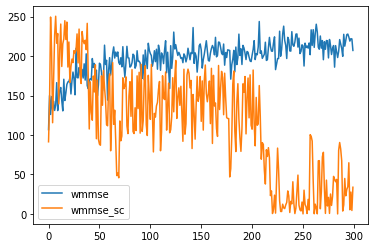

In [102]:
data = pd.DataFrame({
    'wmmse': rates_original_method,
    # 'wmmse_local': rates_local_method,
    'wmmse_sc': rates_sc_method,
    # 'wmmse_lr': rates_lr_method,
})
data.plot();